# VAE Implementation 

In [1]:
import node
import cupy
import numpy as np

GPU Mode


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
num_in_units = 28 * 28 # input size
num_h_units = 400
num_out_units = 20 # hidden size

In [4]:
# Initialize weight parameters with small variance
def initialize(layers):
    for layer in layers:
        if repr(layer) == "Linear":
            W = layer.parameters["W"]
            W.value = cupy.random.normal(0.0, 0.2, size=W.value.shape, dtype=np.float32)

In [5]:
class Encoder(node.Network):
    
    def __init__(self, 
                 num_in_units, 
                 num_h_units, 
                 num_out_units=2): 
        self.layers = [
            node.Linear(num_in_units, num_h_units),
            node.Linear(num_h_units, num_out_units), # Mean Vec
            node.Linear(num_h_units, num_out_units)  # Cov
        ]
        
    def __call__(self, input):
        hidden = input
        hidden = self.layers[0](hidden).relu()
        return self.layers[1](hidden), self.layers[2](hidden)

encoder = Encoder(num_in_units, num_h_units, num_out_units)
initialize(encoder.layers)

In [6]:
class Decoder(node.Network):
    
    def __init__(self, 
                 num_in_units,
                 num_h_units, 
                 num_out_units):
        self.layers = [
            node.Linear(num_in_units, num_h_units),
            node.Linear(num_h_units, num_out_units)
        ]
        
    def __call__(self, input):
        hidden = input
        hidden = self.layers[0](hidden).relu()
        hidden = self.layers[1](hidden).sigmoid()
        return hidden
    
decoder = Decoder(num_out_units, num_h_units, num_in_units)
initialize(decoder.layers)

In [7]:
parameters = encoder.get_parameters() + decoder.get_parameters()
optimizer = node.Adam(parameters, eta=0.001)

In [8]:
from node.node import _two_oprand_op

class KLDivergence(node.Op):
    # Compute KL divergence between two gaussians which have given statistics and zero vector and identity matrix
    
    def __init__(self, mean, ln_var, *args):
        super(KLDivergence, self).__init__()
        self.register(mean, ln_var)
        self.output = self.forward()
    
    def forward(self):
        mean, ln_var = self.cache
        return cupy.sum((mean.value ** 2 + cupy.exp(ln_var.value) - ln_var.value - 1) * 0.5)
    
    def backward(self, error):
        mean, ln_var = self.cache
        mean.accumulate(mean.value)
        ln_var.accumulate(0.5 * cupy.exp(ln_var.value) - 0.5)

@_two_oprand_op
def kl_divergence(self, x):
    return KLDivergence(self, x)

# Register the above function as a method of Node class   
setattr(node.Node, "kl_divergence", kl_divergence)

In [9]:
def reparameterize(mu, ln_var):
    # Convert ln_var to std
    noise = node.Node(cupy.random.standard_normal(mu.value.shape).astype(np.float32))
    return (ln_var * 0.5).exp() * noise + mu

In [10]:
def train(input): 
    optimizer.clear()
    
    # Construct computation graph
    mu, ln_var = encoder(input)
    sample = reparameterize(mu, ln_var)
    output = decoder(sample)
    loss = output.binary_cross_entropy(input, "sum") + mu.kl_divergence(ln_var)
    
    # Update parameters
    loss.backward()
    optimizer.update()
    
    return loss.numpy()

In [11]:
dataset = node.MNIST(train=True, flatten=True)
dataloader = node.DataLoader(dataset, 128)

In [12]:
epoch = 300

In [13]:
for i in range(1, epoch+1):    
    
    loss = 0
    for input, _ in dataloader:
        loss += train(input / 255.0)
    
    if i % 30 == 0:
        print("epoch {0:3}, loss {1:.2f}".format(i, loss / len(dataset)))

epoch  30, loss 172.26
epoch  60, loss 167.20
epoch  90, loss 165.24
epoch 120, loss 164.44
epoch 150, loss 163.57
epoch 180, loss 162.91
epoch 210, loss 162.81
epoch 240, loss 162.46
epoch 270, loss 162.09
epoch 300, loss 161.98


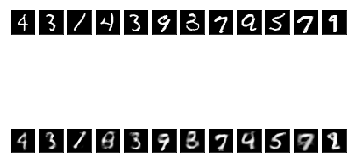

In [14]:
# Use test dataset
dataloader = node.DataLoader(node.MNIST(train=False, flatten=True), 12)
input, _ = next(dataloader)

# Reconstruct
with node.zero_grad():
    output = decoder(reparameterize(*encoder(input / 255)))
output = output.numpy()

_, axis = plt.subplots(2, 12)

# Real images
for i in range(12):
    axis[0][i].imshow(input.numpy()[i].reshape(28, 28), cmap="gray")
    axis[0][i].set_xticks([])
    axis[0][i].set_yticks([])
    
# Reconstruction images
for i in range(12):
    axis[1][i].imshow(output[i].reshape(28, 28), cmap="gray")
    axis[1][i].set_xticks([])
    axis[1][i].set_yticks([])
    
plt.show()

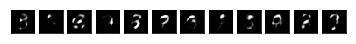

In [29]:
# Sample
sample = node.Node(cupy.random.randn(12, 20).astype(np.float32) * 0.7)
with node.zero_grad():
    output = decoder(sample)
output = output.numpy()

_, axis = plt.subplots(1, 12)

for i in range(12):
    axis[i].imshow(output[i].reshape(28, 28), cmap="gray")
    axis[i].set_xticks([])
    axis[i].set_yticks([])

plt.show()